In [1]:
#%pip install scipy==1.11.4

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import scikitplot as skplt


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from functions.missclassification_rate import missclassification_rate

# Data and model imports

In [3]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

# Evaluation

## Initialization of lists for results table

In [4]:
model_name_result = ['Logistic Regression (undersample)', 'Logistic Regression (oversample)', 'Random forest (undersample)', 'Random forest (oversample)',
         'XGB (undersample)', 'XGB (oversample)', 'LGB (undersample)', 'LGB (oversample)']
recall_result = []
precision_result = []
f1_result = []
acc_result = []
ks_result = []
roc_auc_result = []
pr_auc_result = []
miss_rate_result = []
acc_diff_result = []
recall_diff_result = []
fn_cnt = []

## Logistic Regression

In [5]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

### Predictions

In [6]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown

In [7]:
coef = list(u_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(u_lr.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'coef': coef[0]}).sort_values(by='coef', ascending=False)

,names,coef
43,cat__signature_image_UN,2.338563
118,cat__tranaction_initiate_UN,2.191361
62,cat__transaction_type_P,1.962345
1,cat__currency_eur,1.766336
57,cat__transaction_type_J,1.059576
...,...,...
12,cat__cvv_M,-2.084578
52,cat__transaction_type_E,-2.295646
59,cat__transaction_type_M,-2.880981
66,cat__transaction_type_T,-2.893035


In [8]:
coef = list(o_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(o_lr.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'coef': coef[0]}).sort_values(by='coef', ascending=False)

,names,coef
67,cat__transaction_type_P,1.597869
1,cat__currency_eur,1.485555
125,cat__tranaction_initiate_UN,1.382400
61,cat__transaction_type_J,1.217214
41,cat__signature_image_P,1.048750
...,...,...
3,cat__cvv_C,-1.859098
13,cat__cvv_M,-1.884381
24,cat__cvv_X,-1.925451
64,cat__transaction_type_M,-2.049207


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [9]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_lr = ks.statistic_location
ks_result.append(ks.statistic)

0.7678 p-value: 0.000e+00, loc: 0.5483074047235715


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


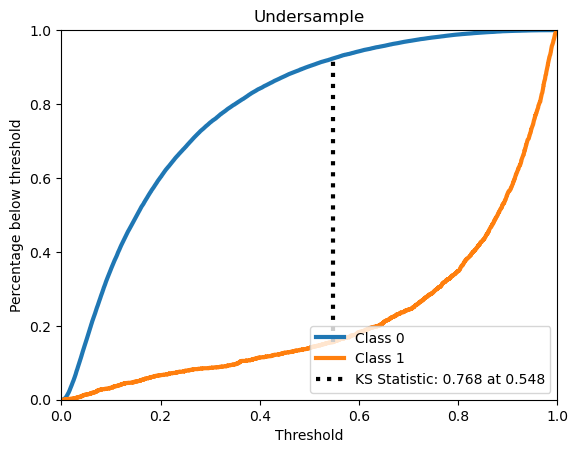

In [10]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [11]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")
loc_over_lr = ks.statistic_location
ks_result.append(ks.statistic)



0.7702 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


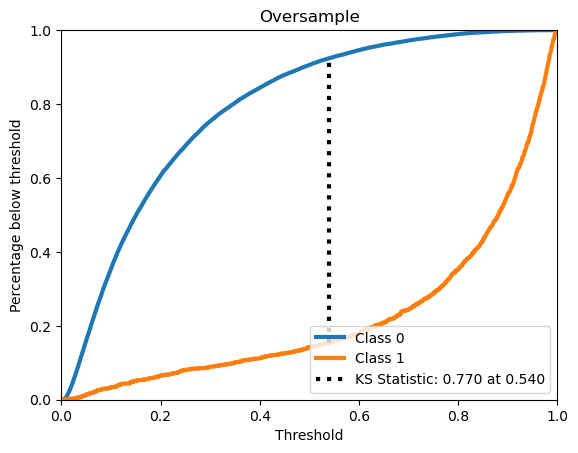

In [12]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [13]:
lr_under_cut_off = loc_under_lr
lr_over_cut_off = loc_over_lr
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

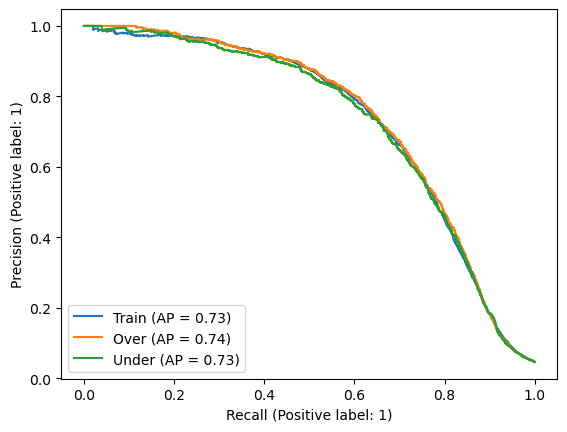

In [14]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

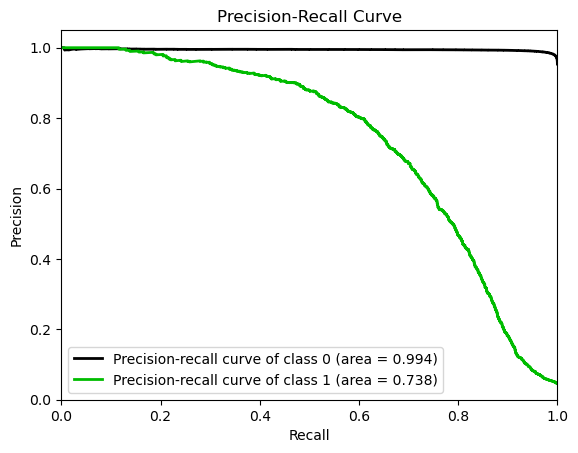

In [15]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba, plot_micro=False)

### Confussion matrix

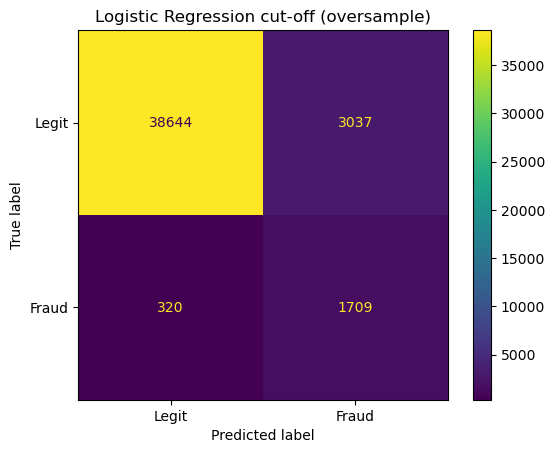

In [16]:
lr_cm_over = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_over, display_labels = ['Legit', 'Fraud'])
lr_cm_over_display.plot()
plt.title('Logistic Regression cut-off (oversample)')
plt.show()

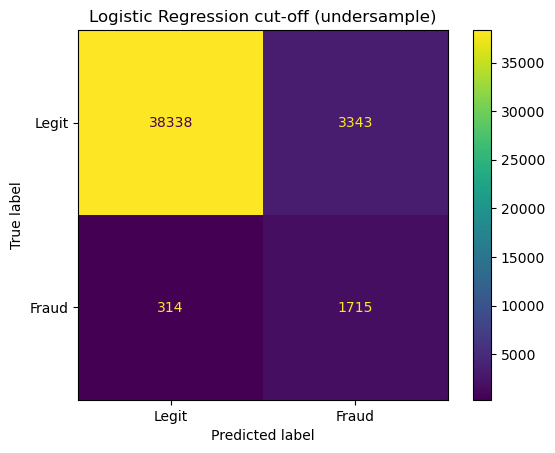

In [17]:
lr_cm_under = confusion_matrix(y_test, lr_under_y_pred_proba_class)
lr_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_under, display_labels = ['Legit', 'Fraud'])
lr_cm_under_display.plot()
plt.title('Logistic Regression cut-off (undersample)')
plt.show()

In [18]:
fn_cnt.append((lr_cm_under[1][0]))
fn_cnt.append((lr_cm_over[1][0]))

### Cumulative Gain

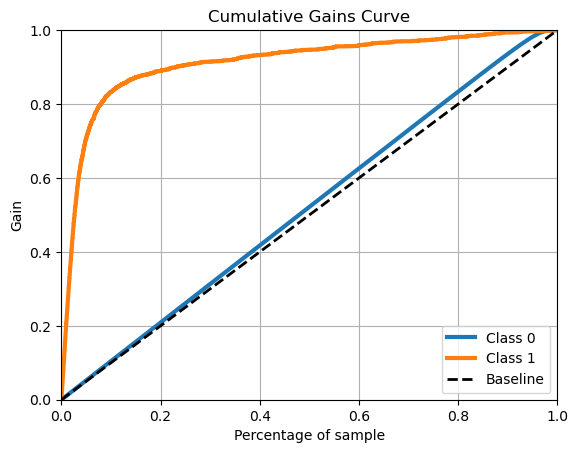

In [19]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

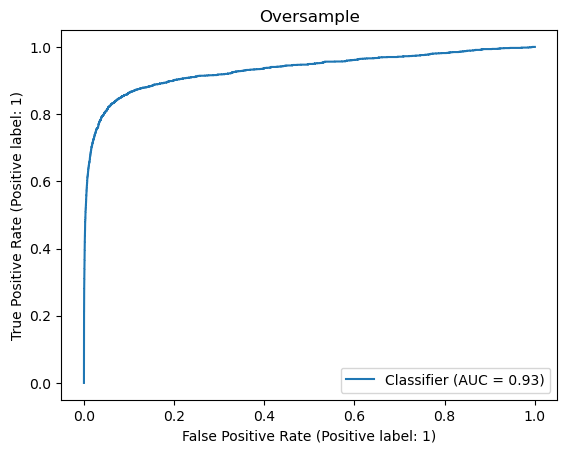

In [20]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [21]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.900282386163078 Test: 0.9231983527796843


In [22]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     41681
           1       0.36      0.84      0.50      2029

    accuracy                           0.92     43710
   macro avg       0.68      0.88      0.73     43710
weighted avg       0.96      0.92      0.94     43710



In [23]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.09654541294898193


# Random Forest

In [24]:
with open('models/under_rf.pkl', 'rb') as f:
    u_rf = pickle.load(f)
f.close()

with open('models/over_rf.pkl', 'rb') as f:
    o_rf = pickle.load(f)
f.close()

### Predictions

In [25]:
rf_under_y_pred = u_rf.predict(X_test)
rf_over_y_pred = o_rf.predict(X_test)

rf_under_y_pred_proba = u_rf.predict_proba(X_test)
rf_over_y_pred_proba =o_rf.predict_proba(X_test)

under_train_pred = u_rf.predict(X_train)
over_train_pred = o_rf.predict(X_train)
under_train_pred_proba = u_rf.predict_proba(X_train)
over_train_pred_proba = o_rf.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categ

In [26]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,0.366337
154,num__acc_age,0.128683
150,num__transaction_amt,0.103750
9,cat__cvv_H,0.026683
152,num__historic_velocity,0.025028
...,...,...
82,cat__transaction_env_K,0.000000
83,cat__transaction_env_L,0.000000
42,cat__signature_image_T,0.000000
84,cat__transaction_env_M,0.000000


In [27]:
importances = list(o_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(o_rf.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
157,num__transaction_adj_amt,0.457881
160,num__acc_age,0.116830
156,num__transaction_amt,0.076965
158,num__historic_velocity,0.026616
9,cat__cvv_H,0.016415
...,...,...
65,cat__transaction_type_M,0.000000
64,cat__transaction_type_L,0.000000
46,cat__signature_image_T,0.000000
63,cat__transaction_type_K,0.000000


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [28]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7594 p-value: 0.000e+00, loc: 0.48484617419285914


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


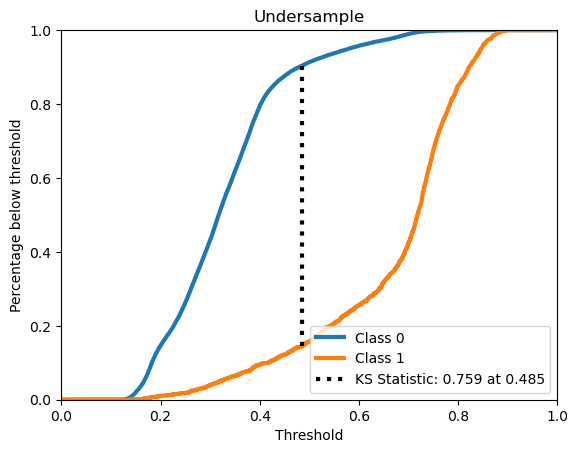

In [29]:
skplt.metrics.plot_ks_statistic(y_test, rf_under_y_pred_proba, title='Undersample')
plt.show()

In [30]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7936 p-value: 0.000e+00 loc: 0.4308328624480769


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


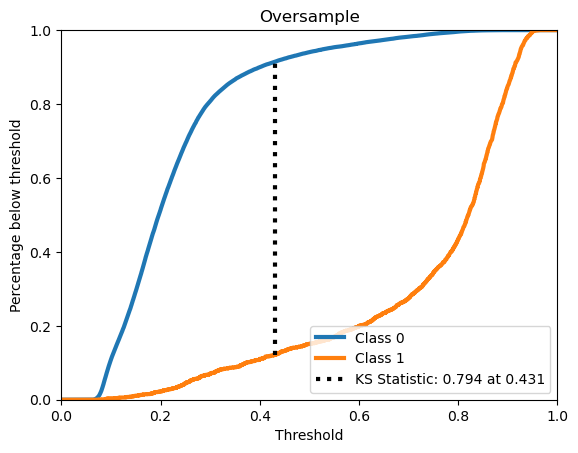

In [31]:
skplt.metrics.plot_ks_statistic(y_test, rf_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [32]:
rf_under_cut_off = loc_under_rf
rf_over_cut_off = loc_over_rf
rf_over_y_pred_proba_class = np.where(rf_over_y_pred_proba[:, 1] > rf_under_cut_off, 1, 0)
rf_under_y_pred_proba_class = np.where(rf_under_y_pred_proba[:, 1] > rf_over_cut_off, 1, 0)

### Precision-Recall Curve

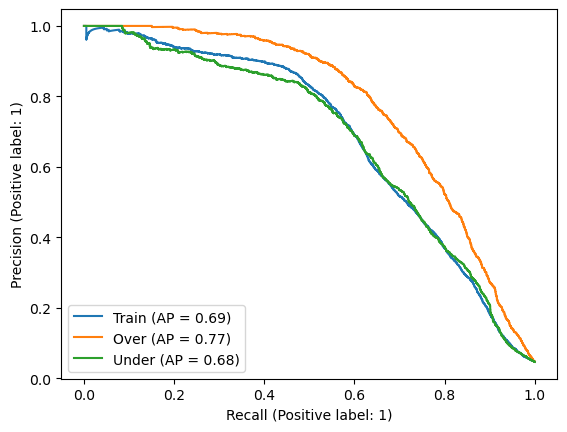

In [33]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

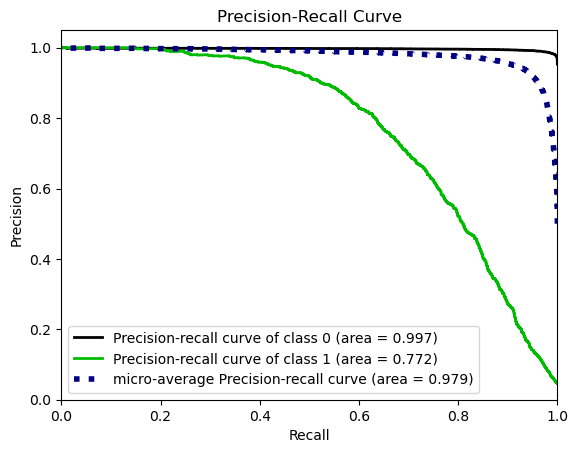

In [34]:
skplt.metrics.plot_precision_recall(y_test, rf_over_y_pred_proba)

### Confussion matrix

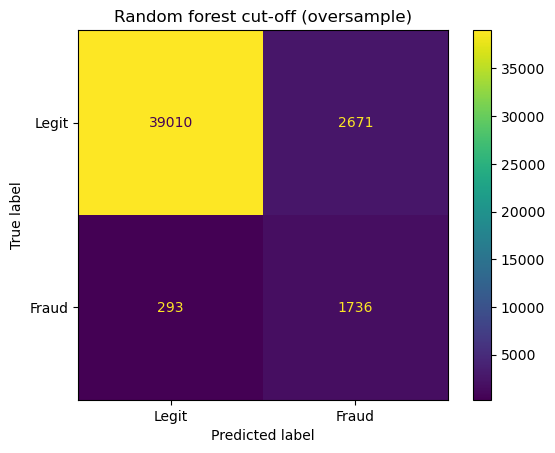

In [35]:
rf_cm_over = confusion_matrix(y_test, rf_over_y_pred_proba_class)
rf_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_over, display_labels = ['Legit', 'Fraud'])
rf_cm_over_display.plot()
plt.title('Random forest cut-off (oversample)')
plt.show()

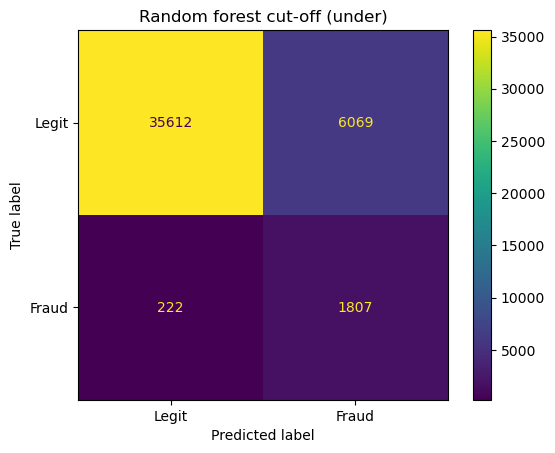

In [36]:
rf_cm_under = confusion_matrix(y_test, rf_under_y_pred_proba_class)
rf_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_under, display_labels = ['Legit', 'Fraud'])
rf_cm_under_display.plot()
plt.title('Random forest cut-off (under)')
plt.show()

In [37]:
fn_cnt.append((rf_cm_under[1][0]))
fn_cnt.append((rf_cm_over[1][0]))

### Cumulative Gain

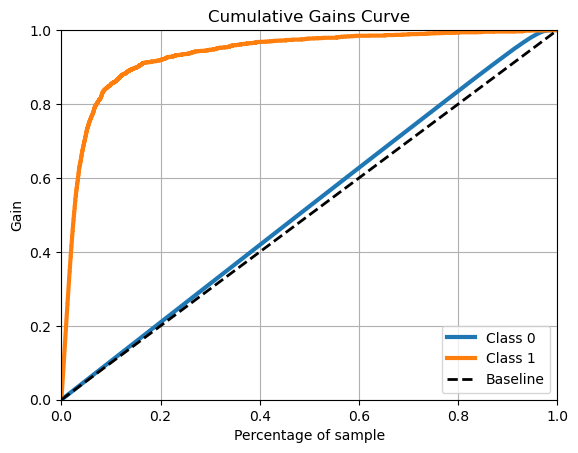

In [38]:
skplt.metrics.plot_cumulative_gain(y_test, rf_over_y_pred_proba)
plt.show()

### ROC

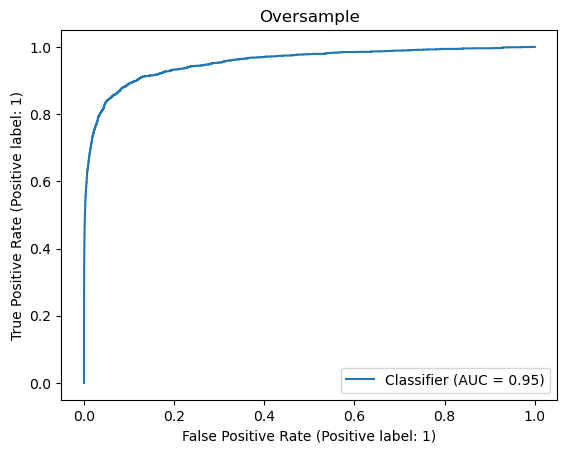

In [39]:
RocCurveDisplay.from_predictions(
    y_test, rf_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [40]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, rf_over_y_pred_proba_class)}')

Accuracy Train: 0.9345020982860729 Test: 0.9321894303363075


In [41]:
print(classification_report(y_test, rf_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41681
           1       0.39      0.86      0.54      2029

    accuracy                           0.93     43710
   macro avg       0.69      0.90      0.75     43710
weighted avg       0.96      0.93      0.94     43710



In [42]:
print(f'The missclasification rate is: {missclassification_rate(y_test, rf_over_y_pred)}')

The missclasification rate is: 0.06387554335392359


# XGBoosting

In [43]:
with open('models/under_xgb.pkl', 'rb') as f:
    u_xgb = pickle.load(f)
f.close()

with open('models/over_xgb.pkl', 'rb') as f:
    o_xgb = pickle.load(f)
f.close()

### Predictions

In [44]:
xgb_under_y_pred = u_xgb.predict(X_test)
xgb_over_y_pred = o_xgb.predict(X_test)

xgb_under_y_pred_proba = u_xgb.predict_proba(X_test)
xgb_over_y_pred_proba =o_xgb.predict_proba(X_test)

under_train_pred = u_xgb.predict(X_train)
over_train_pred = o_xgb.predict(X_train)
under_train_pred_proba = u_xgb.predict_proba(X_train)
over_train_pred_proba = o_xgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

In [45]:
importances = list(u_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(u_xgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
153,num__transaction_adj_amt,0.082908
156,num__acc_age,0.035129
74,cat__transaction_type_X,0.034186
9,cat__cvv_H,0.032150
19,cat__cvv_S,0.029268
...,...,...
122,cat__tranaction_initiate_V,0.000000
124,cat__tranaction_initiate_X,0.000000
95,cat__transaction_env_UN,0.000000
49,cat__signature_image_Y,0.000000


In [46]:
importances = list(o_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(o_xgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,0.075338
22,cat__cvv_V,0.037092
154,num__acc_age,0.035744
14,cat__cvv_N,0.033122
9,cat__cvv_H,0.028656
...,...,...
25,cat__cvv_Y,0.000000
30,cat__signature_image_E,0.000000
36,cat__signature_image_M,0.000000
48,cat__signature_image_Y,0.000000


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [47]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8111 p-value: 0.000e+00 loc: 0.5429579019546509


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


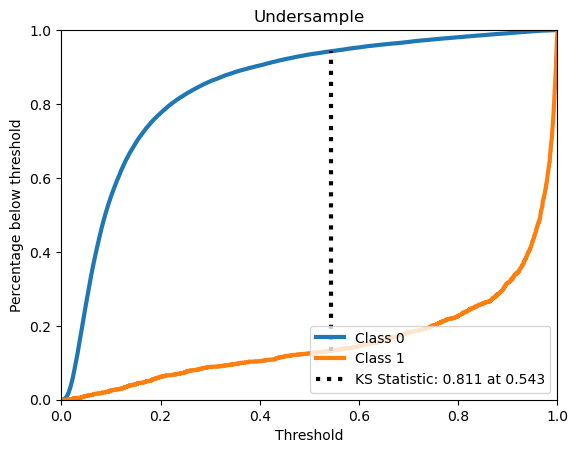

In [48]:
skplt.metrics.plot_ks_statistic(y_test, xgb_under_y_pred_proba, title='Undersample')
plt.show()

In [49]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8201 p-value: 0.000e+00 loc: 0.5494405627250671


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


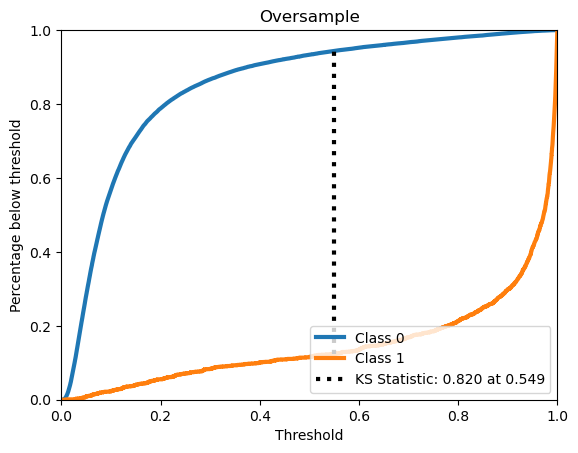

In [50]:
skplt.metrics.plot_ks_statistic(y_test, xgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [51]:
xgb_under_cut_off = loc_under_xgb
xgb_over_cut_off = loc_over_xgb
xgb_over_y_pred_proba_class = np.where(xgb_over_y_pred_proba[:, 1] > xgb_under_cut_off, 1, 0)
xgb_under_y_pred_proba_class = np.where(xgb_under_y_pred_proba[:, 1] > xgb_over_cut_off, 1, 0)

### Precision-Recall Curve

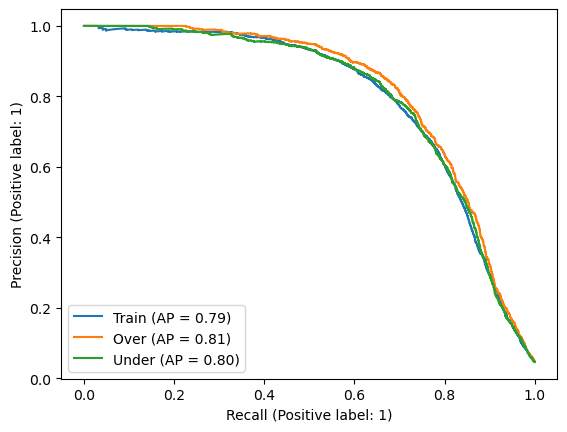

In [52]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

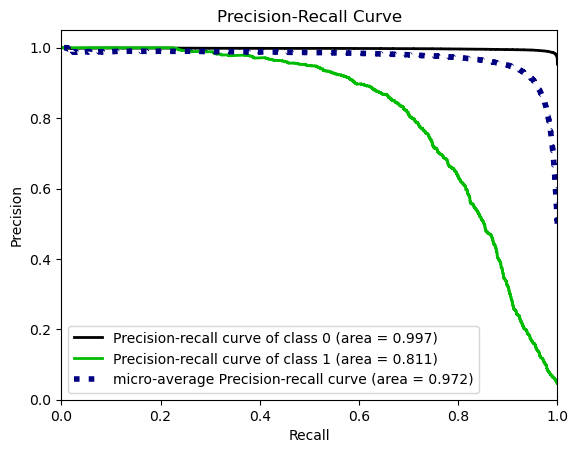

In [53]:
skplt.metrics.plot_precision_recall(y_test, xgb_over_y_pred_proba)

### Confussion matrix

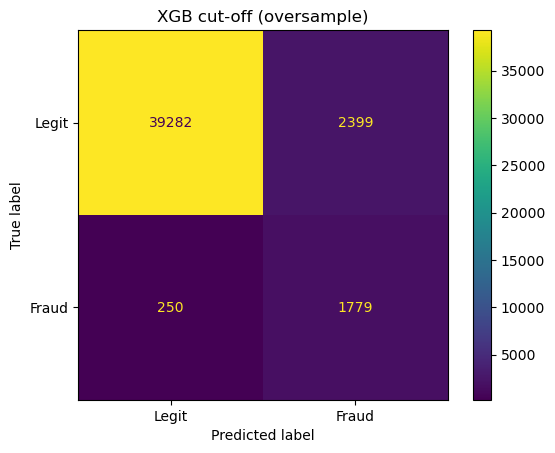

In [54]:
xgb_cm_over = confusion_matrix(y_test, xgb_over_y_pred_proba_class)
xgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_over, display_labels = ['Legit', 'Fraud'])
xgb_cm_over_display.plot()
plt.title('XGB cut-off (oversample)')
plt.show()

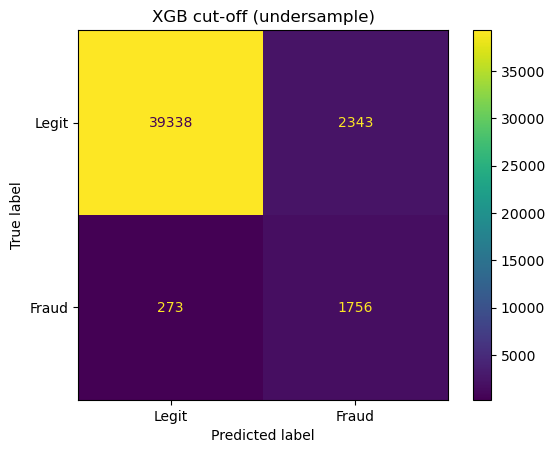

In [55]:
xgb_cm_under = confusion_matrix(y_test, xgb_under_y_pred_proba_class)
xgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_under, display_labels = ['Legit', 'Fraud'])
xgb_cm_under_display.plot()
plt.title('XGB cut-off (undersample)')
plt.show()

In [56]:
fn_cnt.append((xgb_cm_under[1][0]))
fn_cnt.append((xgb_cm_over[1][0]))

### Cumulative Gain

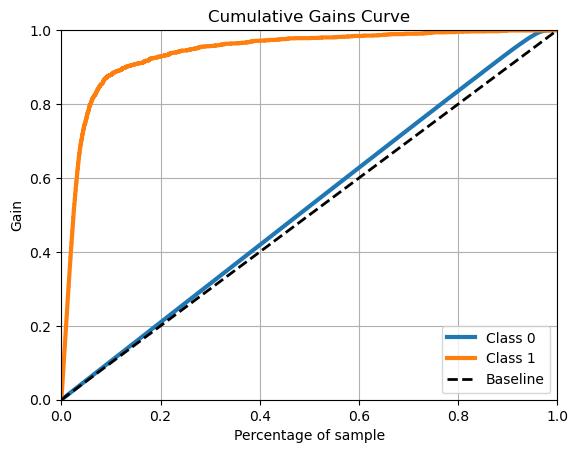

In [57]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_over_y_pred_proba)
plt.show()

### ROC

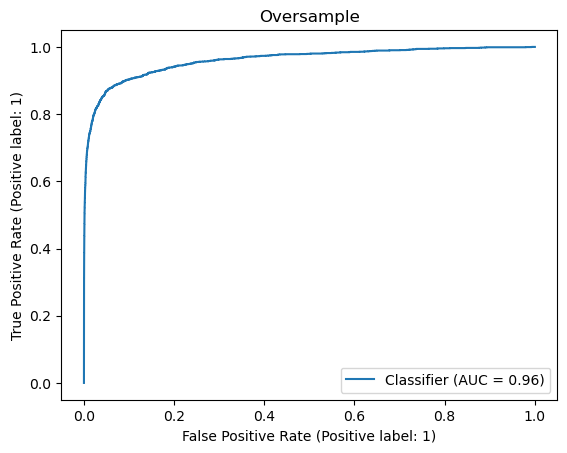

In [58]:
RocCurveDisplay.from_predictions(
    y_test, xgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [59]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, xgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9287563242734439 Test: 0.9393960192175703


In [60]:
print(classification_report(y_test, xgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     41681
           1       0.43      0.88      0.57      2029

    accuracy                           0.94     43710
   macro avg       0.71      0.91      0.77     43710
weighted avg       0.97      0.94      0.95     43710



In [61]:
print(f'The missclasification rate is: {missclassification_rate(y_test, xgb_over_y_pred)}')

The missclasification rate is: 0.06902310684053992


# LGBoosting

In [62]:
with open('models/under_lgb.pkl', 'rb') as f:
    u_lgb = pickle.load(f)
f.close()

with open('models/over_lgb.pkl', 'rb') as f:
    o_lgb = pickle.load(f)
f.close()

### Predictions

In [63]:
lgb_under_y_pred = u_lgb.predict(X_test)
lgb_over_y_pred = o_lgb.predict(X_test)

lgb_under_y_pred_proba = u_lgb.predict_proba(X_test)
lgb_over_y_pred_proba =o_lgb.predict_proba(X_test)

under_train_pred = u_lgb.predict(X_train)
over_train_pred = o_lgb.predict(X_train)
under_train_pred_proba = u_lgb.predict_proba(X_train)
over_train_pred_proba = o_lgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. T

In [64]:
importances = list(u_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(u_lgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
152,num__transaction_adj_amt,57
155,num__acc_age,46
151,num__transaction_amt,30
153,num__historic_velocity,27
2,cat__currency_usd,21
...,...,...
60,cat__transaction_type_K,0
59,cat__transaction_type_J,0
54,cat__transaction_type_E,0
51,cat__transaction_type_B,0


In [65]:
importances = list(o_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(o_lgb.best_estimator_[:-1].get_feature_names_out())
pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)

,names,importance
151,num__transaction_adj_amt,97
154,num__acc_age,54
152,num__historic_velocity,32
150,num__transaction_amt,30
2,cat__currency_usd,25
...,...,...
55,cat__transaction_type_G,0
57,cat__transaction_type_I,0
58,cat__transaction_type_J,0
59,cat__transaction_type_K,0


### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [66]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7386 p-value: 0.000e+00 loc: 0.49434297624526874


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


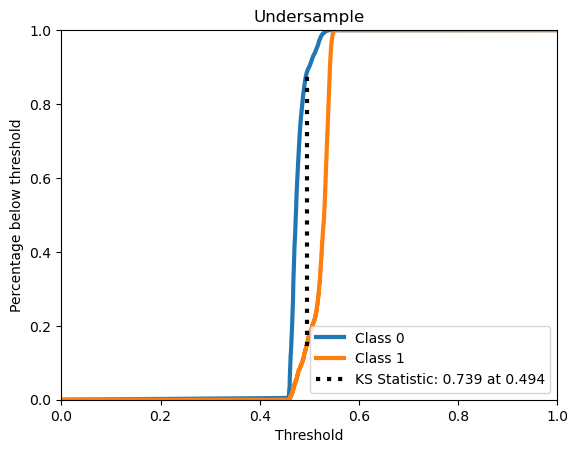

In [67]:
skplt.metrics.plot_ks_statistic(y_test, lgb_under_y_pred_proba, title='Undersample')
plt.show()

In [68]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.6957 p-value: 0.000e+00 loc: 0.47648684813891573


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


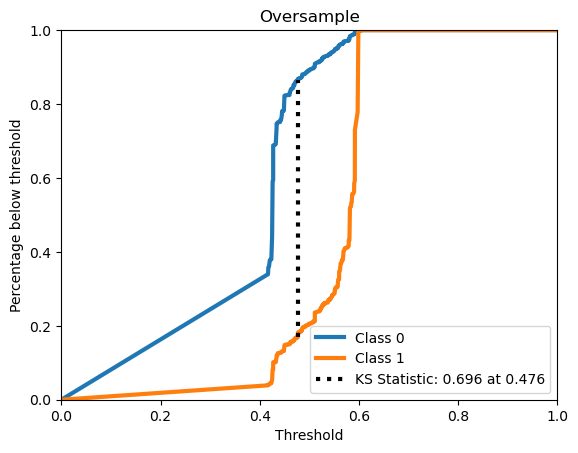

In [69]:
skplt.metrics.plot_ks_statistic(y_test, lgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [70]:
lgb_under_cut_off = loc_under_lgb
lgb_over_cut_off = loc_over_lgb
lgb_over_y_pred_proba_class = np.where(lgb_over_y_pred_proba[:, 1] > lgb_under_cut_off, 1, 0)
lgb_under_y_pred_proba_class = np.where(lgb_under_y_pred_proba[:, 1] > lgb_over_cut_off, 1, 0)

### Precision-Recall Curve

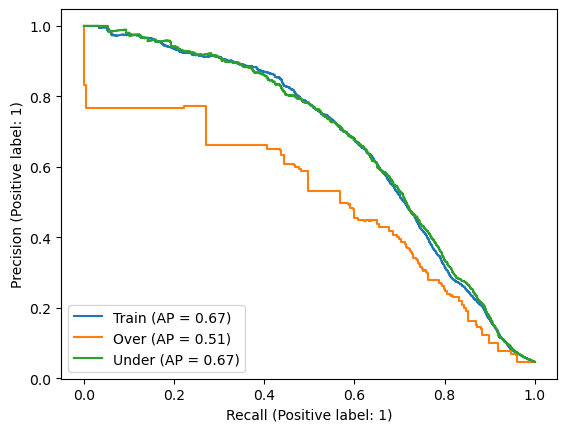

In [71]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

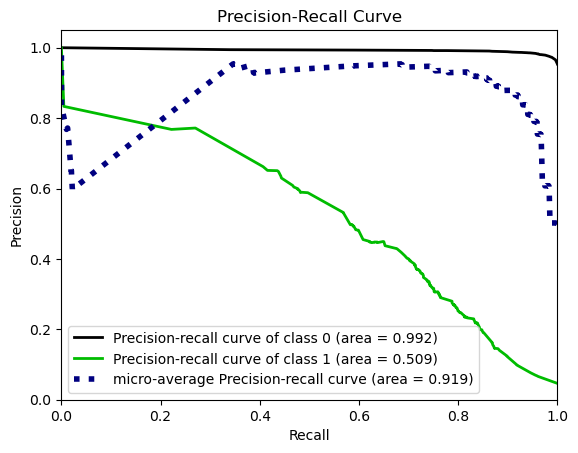

In [72]:
skplt.metrics.plot_precision_recall(y_test, lgb_over_y_pred_proba)

### Confussion matrix

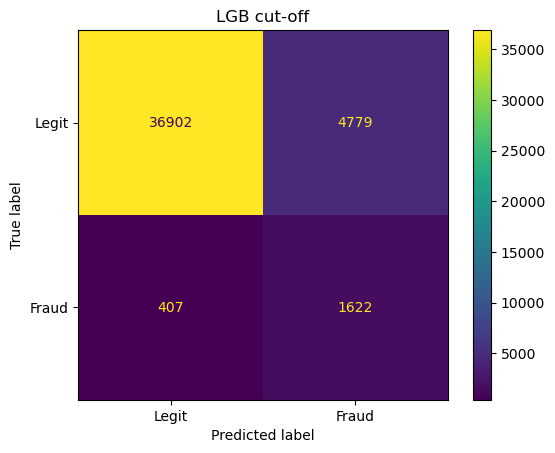

In [73]:
lgb_cm_over = confusion_matrix(y_test, lgb_over_y_pred_proba_class)
lgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_over, display_labels = ['Legit', 'Fraud'])
lgb_cm_over_display.plot()
plt.title('LGB cut-off')
plt.show()

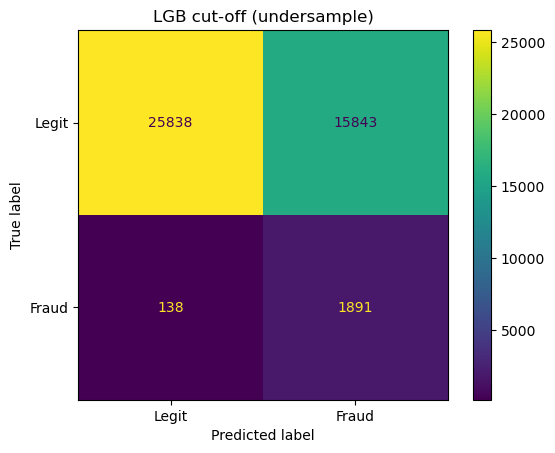

In [74]:
lgb_cm_under = confusion_matrix(y_test, lgb_under_y_pred_proba_class)
lgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_under, display_labels = ['Legit', 'Fraud'])
lgb_cm_under_display.plot()
plt.title('LGB cut-off (undersample)')
plt.show()

In [75]:
fn_cnt.append((lgb_cm_under[1][0]))
fn_cnt.append((lgb_cm_over[1][0]))

### Cumulative Gain

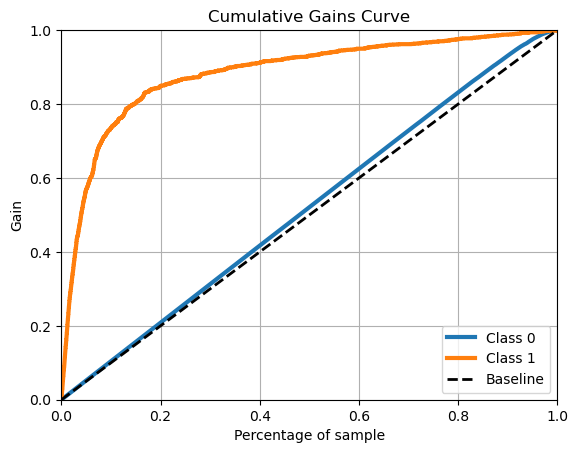

In [76]:
skplt.metrics.plot_cumulative_gain(y_test, lgb_over_y_pred_proba)
plt.show()

### ROC

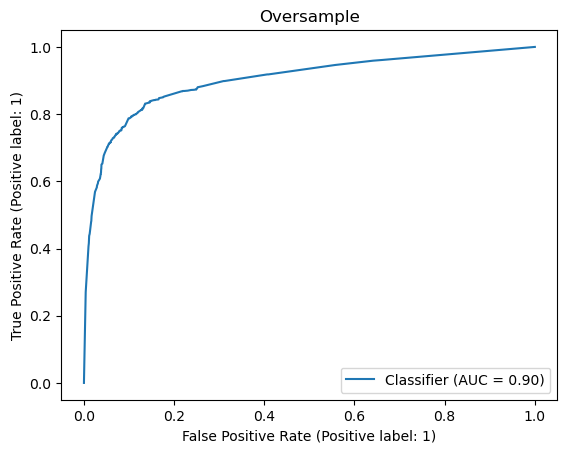

In [77]:
RocCurveDisplay.from_predictions(
    y_test, lgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [78]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lgb_over_y_pred_proba_class)}')

Accuracy Train: 0.8845746558418638 Test: 0.8813543811484786


In [79]:
print(classification_report(y_test, lgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     41681
           1       0.25      0.80      0.38      2029

    accuracy                           0.88     43710
   macro avg       0.62      0.84      0.66     43710
weighted avg       0.95      0.88      0.91     43710



In [80]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lgb_over_y_pred)}')

The missclasification rate is: 0.1123541523678792


# Aggregated Results

In [81]:
# Logistic Regression
recall_result.append(recall_score(y_test, lr_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lr_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lr_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lr_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lr_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lr_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lr_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lr_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lr_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lr_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lr_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lr_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lr_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lr_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lr_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lr_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lr_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lr_over_y_pred_proba_class)))

In [82]:
# Random Forest
recall_result.append(recall_score(y_test, rf_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, rf_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, rf_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, rf_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, rf_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, rf_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, rf_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, rf_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, rf_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, rf_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, rf_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, rf_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, rf_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, rf_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, rf_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, rf_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, rf_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, rf_over_y_pred_proba_class)))

In [83]:
# XGB
recall_result.append(recall_score(y_test, xgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, xgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, xgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, xgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, xgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, xgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, xgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, xgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, xgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, xgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, xgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, xgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, xgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, xgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, xgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, xgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, xgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, xgb_over_y_pred_proba_class)))

In [84]:
# LGB
recall_result.append(recall_score(y_test, lgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lgb_over_y_pred_proba_class)))

In [85]:
wyniki = pd.DataFrame(
    {'Model': model_name_result,'Recall': recall_result, 'Precision':precision_result,'F1': f1_result,
    'Accuracy': acc_result, 'KS' : ks_result, 'ROC_AUC': roc_auc_result,'PR_AUC': pr_auc_result,
    'Missclassification_rate': miss_rate_result, 'Acc_diff': acc_diff_result,'Recall_diff': recall_diff_result, 'False_negatives': fn_cnt}
    )


In [86]:
wyniki

,Model,Recall,Precision,F1,Accuracy,KS,ROC_AUC,PR_AUC,Missclassification_rate,Acc_diff,Recall_diff,False_negatives
0,Logistic Regression (undersample),0.845244,0.339067,0.483985,0.916335,0.767821,0.931481,0.726933,0.083665,0.021436,0.027753,314
1,Logistic Regression (oversample),0.842287,0.360093,0.504502,0.923198,0.770152,0.932261,0.737625,0.076802,0.038624,0.041907,320
2,Random forest (undersample),0.890586,0.229431,0.364866,0.856074,0.759387,0.930311,0.679477,0.143926,0.038825,0.073096,222
3,Random forest (oversample),0.855594,0.393919,0.539466,0.932189,0.793587,0.954649,0.771864,0.067811,0.047615,0.055214,293
4,XGB (undersample),0.865451,0.428397,0.573107,0.940151,0.811116,0.957543,0.796131,0.059849,0.045252,0.047960,273
5,XGB (oversample),0.876787,0.425802,0.573224,0.939396,0.820081,0.961306,0.811351,0.060604,0.054821,0.076406,250
6,LGB (undersample),0.931986,0.106631,0.191368,0.634386,0.738621,0.924815,0.670525,0.365614,0.260514,0.114496,138
7,LGB (oversample),0.799409,0.253398,0.384816,0.881354,0.695675,0.902464,0.508653,0.118646,0.003220,0.000972,407


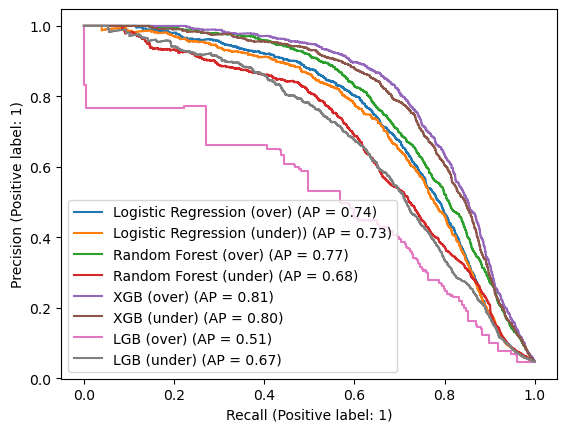

In [87]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= "Logistic Regression (over)")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Logistic Regression (under))")

PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= "Random Forest (over)")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Random Forest (under)")

PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= "XGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="XGB (under)")

PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= "LGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="LGB (under)")
plt.show()

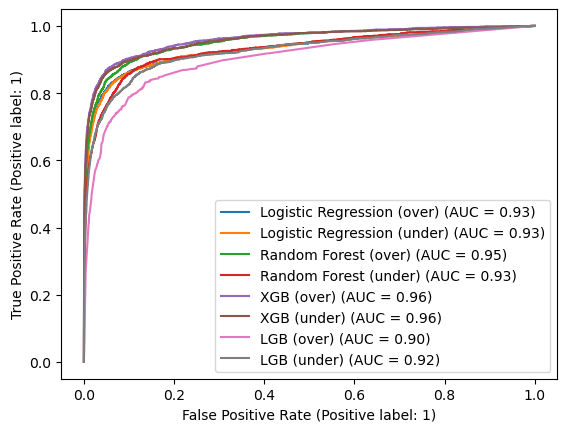

In [88]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= 'Logistic Regression (over)')
RocCurveDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name='Logistic Regression (under)')

RocCurveDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= 'Random Forest (over)')
RocCurveDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name='Random Forest (under)')

RocCurveDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= 'XGB (over)')
RocCurveDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name='XGB (under)')

RocCurveDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= 'LGB (over)')
RocCurveDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name='LGB (under)')
plt.show()

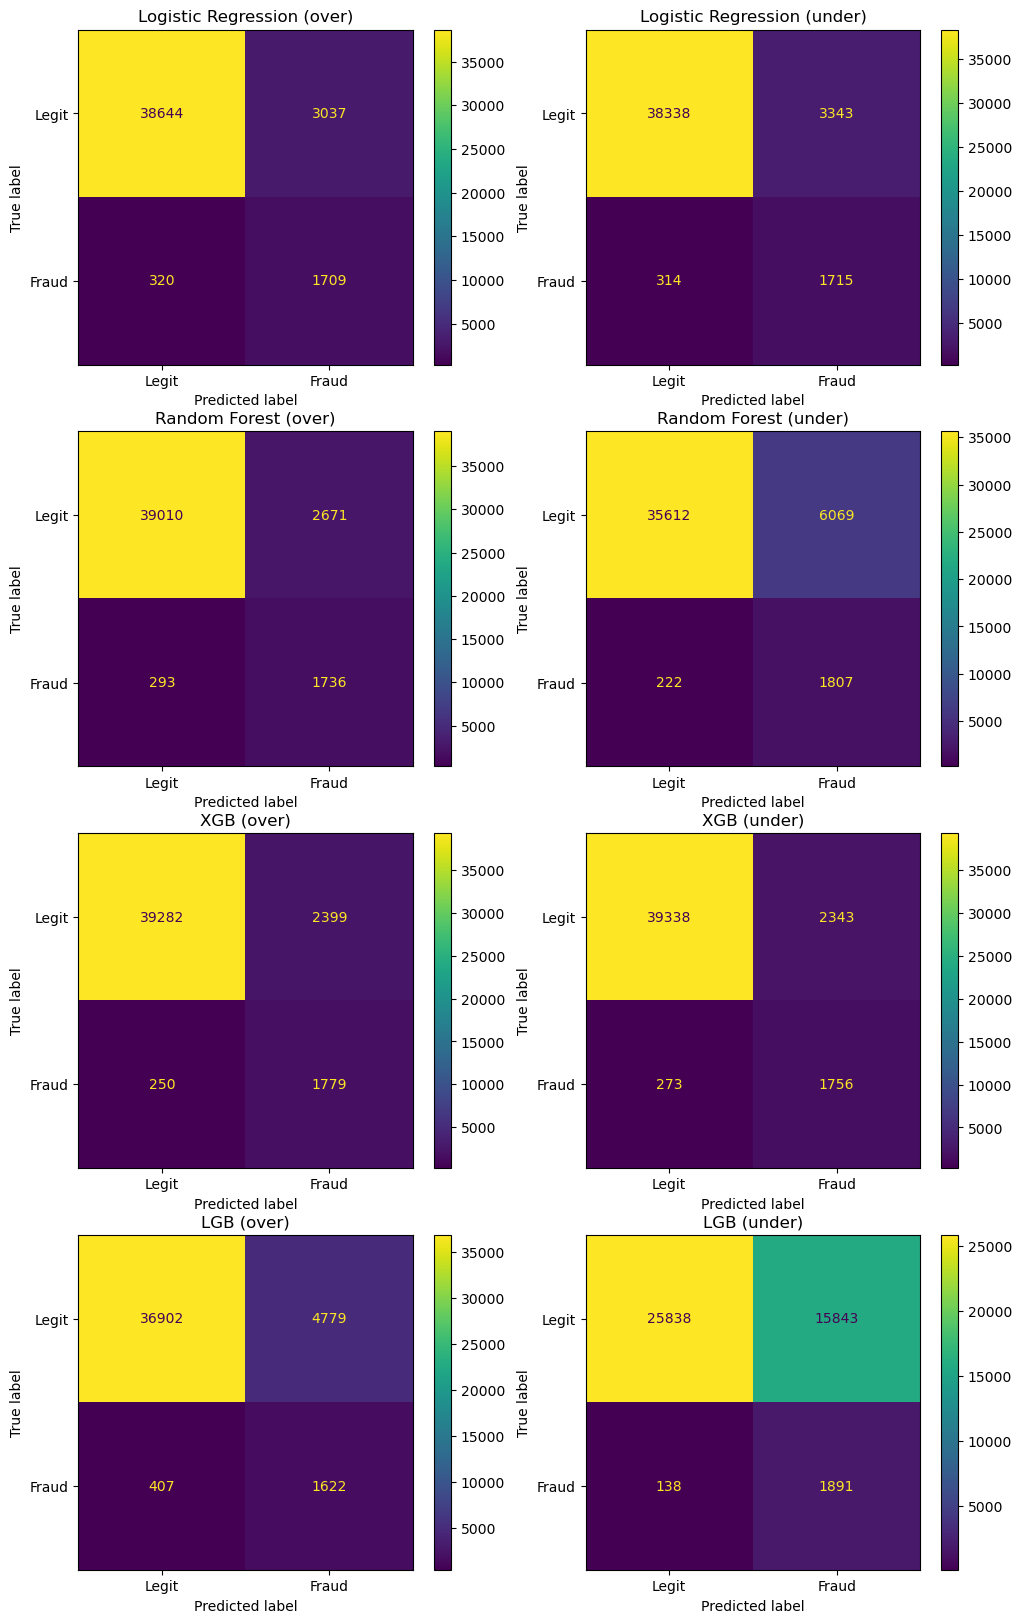

In [89]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
lr_cm_over_display.plot(ax=axs[0][0])
axs[0][0].set_title('Logistic Regression (over)')
rf_cm_over_display.plot(ax=axs[1][0])
axs[1][0].set_title('Random Forest (over)')
xgb_cm_over_display.plot(ax=axs[2][0])
axs[2][0].set_title('XGB (over)')
lgb_cm_over_display.plot(ax=axs[3][0])
axs[3][0].set_title('LGB (over)')
lr_cm_under_display.plot(ax=axs[0][1])
axs[0][1].set_title('Logistic Regression (under)')
rf_cm_under_display.plot(ax=axs[1][1])
axs[1][1].set_title('Random Forest (under)')
xgb_cm_under_display.plot(ax=axs[2][1])
axs[2][1].set_title('XGB (under)')
lgb_cm_under_display.plot(ax=axs[3][1])
axs[3][1].set_title('LGB (under)')
plt.show()